In [35]:
 # ! pip install langgraph langchain_openai langchain_huggingface

In [36]:
# pip install google-generativeai


In [37]:
import os
import sys
from typing import TypedDict, List, Dict, Any, Optional
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage
import sys

In [38]:
import google.generativeai as genai
from dotenv import load_dotenv

load_dotenv()

try:
    API_KEY = os.environ["gemini_api_key"]
except KeyError:
    print("Error: The 'gemini_api_key' environment variable is not set.")
    sys.exit(1)

genai.configure(api_key=API_KEY)

model = genai.GenerativeModel(
    model_name="gemini-2.5-pro",        
)

Email Related work

In [39]:
class EmailState(TypedDict):
    email: Dict[str, Any]
    is_spam: Optional[bool]
    spam_reason: Optional[bool]
    email_category:Optional[bool]
    email_draft:Optional[bool]
    messages: List[Dict[str,Any]]

In [40]:
def read_email(state: EmailState):
    email = state["email"]
    print(f"Alfred is processing an email from {email['sender']} with subject: {email['subject']}")
    return {}


def classify_email(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the trusted butler of Mr Wayne and his SECRET identity Batman, analyze this email carefully and determine if it is spam or legitimate.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Answer only with 'SPAM' or 'HAM'.
"""

    response = model.generate_content(prompt)
    response_text = response.text.strip().lower()
    print(f"Gemini response: {response_text}")

    is_spam = response_text == "spam"

    if not is_spam:
        new_messages = state.get("messages", []) + [
            {"role": "user", "content": prompt},
            {"role": "assistant", "content": response.text},
        ]
    else:
        new_messages = state.get("messages", [])

    return {
        "is_spam": is_spam,
        "messages": new_messages
    }


In [41]:
def handle_spam(state: EmailState):
    print(f"Alfred has marked the email as spam.")
    print("The email has been moved to the spam folder.")
    return {}

In [42]:
def drafting_response(state: EmailState):
    email = state["email"]

    prompt = f"""
As Alfred the butler, draft a polite preliminary response to this email.

Email:
From: {email['sender']}
Subject: {email['subject']}
Body: {email['body']}

Draft a brief, professional response that Mr. Wayne can review and personalize before sending.
"""

    response = model.generate_content(prompt)

    draft_text = response.text.strip()

    new_messages = state.get("messages", []) + [
        {"role": "user", "content": prompt},
        {"role": "assistant", "content": draft_text},
    ]

    return {
        "email_draft": draft_text,
        "messages": new_messages
    }


In [43]:
def notify_mr_wayne(state: EmailState):
    email = state["email"]

    print("\n" + "=" * 50)
    print(f"Sir, you've received an email from {email['sender']}.")
    print(f"Subject: {email['subject']}")
    print("\nI've prepared a draft response for your review:")
    print("-" * 50)
    print(state["email_draft"])
    print("=" * 50 + "\n")

    return {}

In [44]:
def route_email(state: EmailState) -> str:
    if state["is_spam"]:
        return "spam"
    else:
        return "legitimate"

In [45]:
email_graph = StateGraph(EmailState)

# Add nodes
email_graph.add_node("read_email", read_email)  # the read_email node executes the read_mail function
email_graph.add_node("classify_email", classify_email)  # the classify_email node will execute the classify_email function
email_graph.add_node("handle_spam", handle_spam) 
email_graph.add_node("drafting_response", drafting_response)  
email_graph.add_node("notify_mr_wayne", notify_mr_wayne)  

Routing Logic

In [46]:
email_graph.add_edge(START, "read_email")
email_graph.add_edge("read_email", "classify_email")
email_graph.add_conditional_edges("classify_email", route_email,{
    "spam": "handle_spam",
    "legitimate": "drafting_response"
})

email_graph.add_edge("handle_spam", END)
email_graph.add_edge("drafting_response", "notify_mr_wayne")
email_graph.add_edge("notify_mr_wayne", END)

Create State Graphs

In [47]:

# Compile the graph
compiled_graph = email_graph.compile()

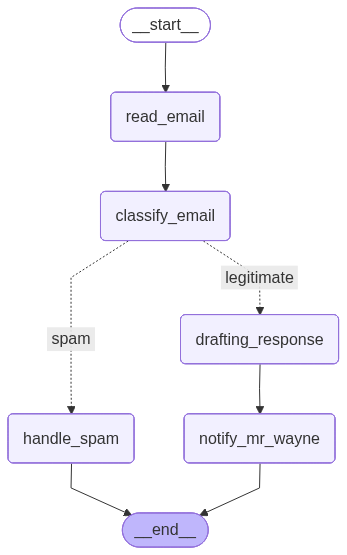

In [48]:
from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


In [49]:
legitimate_email = {
    "sender": "Joker",
    "subject": "Found you Batman!",
    "body": "Mr. Wayne, I found your secret identity! I know you're Batman! There's no denying it. I'm coming to find you soon. JOKER"
}

spam_email = {
    "sender": "Crypto bro",
    "subject": "The best investment of 2025",
    "body": "Mr Wayne, I just launched an ALT coin and want you to buy some!"
}

print("\nProcessing legitimate email...")
legitimate_result = compiled_graph.invoke({
    "email": legitimate_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})

print("\nProcessing spam email...")
spam_result = compiled_graph.invoke({
    "email": spam_email,
    "is_spam": None,
    "spam_reason": None,
    "email_category": None,
    "email_draft": None,
    "messages": []
})


Processing legitimate email...
Alfred is processing an email from Joker with subject: Found you Batman!
Gemini response: ham

Sir, you've received an email from Joker.
Subject: Found you Batman!

I've prepared a draft response for your review:
--------------------------------------------------
Of course, sir. I have prepared a preliminary draft for your review. It is designed to be dismissive, professional, and to create a formal record without lending any credence to the sender's rather... theatrical accusations.

Here is the draft.

***

**To:** Joker
**Subject:** Re: Your Correspondence

To Whom It May Concern,

Thank you for your message.

Mr. Wayne’s office receives a high volume of correspondence, and it appears your email has been misdirected or is based on a misunderstanding.

While Mr. Wayne is, of course, a great supporter of Batman's work to keep Gotham safe, I can assure you that you have reached the wrong individual. Your message has been noted for our records.

We will b